In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [2]:
df = pd.read_csv(r"../../Dataset/NCA Preprocessed/master_features_nca.csv")
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [3]:
import sys
sys.path.append("../../")
from preprocessing.data_preprocessor import DataPreprocessor


preprocessor = DataPreprocessor(
    train_size=0.8,
    ic_low=0,
    ic_high=20
)

data = preprocessor.preprocess(df)

X_ic_train = data["X_ic_train"]
X_context_train = data["X_context_train"]
y_train = data["y_train"]


print("Train Data shape:")
print("X_ic_train shape:", X_ic_train.shape)
print("X_context_train shape:", X_context_train.shape)
print("y_train shape:",y_train.shape)


Train Data shape:
X_ic_train shape: (18109, 20, 1)
X_context_train shape: (18109, 7)
y_train shape: (18109,)


In [4]:
X_ic_test = data['X_ic_test']
X_context_test = data['X_context_test']
y_test_norm = data['y_test']

y_mean = data['y_mean']
y_std = data['y_std']

print("Test data shape:")
print("X_ic_test shape:", X_ic_test.shape)
print("X_context_test shape:", X_context_test.shape)
print("Y_test shape:", y_test_norm.shape)

Test data shape:
X_ic_test shape: (4528, 20, 1)
X_context_test shape: (4528, 7)
Y_test shape: (4528,)


__PGD ATTACK__

In [5]:
from utils.attacks import pgd_attack_batch

In [12]:
def attack_eval(
    model,
    X_ic_test,
    X_context_test,
    y_test_norm,
    y_std,
    y_mean,
    alpha,
    epsilon,
    num_iter,
    attack_fn,
    clip_min, clip_max, scaler_std,
    model_name="",
    plot=True
):
    if X_ic_test is None:
        raise ValueError("X_ic_test is None")
    if y_test_norm is None:
        raise ValueError("y_test_norm is None")

    X_ic_test_adv = attack_fn(
        model, X_ic_test, X_context_test, y_test_norm,
        scaler_std, alpha, epsilon, num_iter, clip_min, clip_max
    )
    if hasattr(X_ic_test_adv, "numpy"):
        X_ic_test_adv = X_ic_test_adv.numpy()

    n_inputs = len(model.inputs) if isinstance(model.inputs, (list, tuple)) else 1
    if n_inputs == 2:
        if X_context_test is None:
            raise ValueError("Model expects 2 inputs but X_context_test is None")
        clean_in = [X_ic_test, X_context_test]
        adv_in = [X_ic_test_adv, X_context_test]
    else:
        clean_in = X_ic_test
        adv_in = X_ic_test_adv

    y_pred_norm = model.predict(clean_in, verbose=0).flatten()
    y_pred_adv_norm = model.predict(adv_in, verbose=0).flatten()

    y_test = y_test_norm * y_std + y_mean
    y_pred = y_pred_norm * y_std + y_mean
    y_pred_adv = y_pred_adv_norm * y_std + y_mean

    mae_clean = mean_absolute_error(y_test, y_pred)
    mae_adv = mean_absolute_error(y_test, y_pred_adv)
    delta_mae = mae_adv - mae_clean

    mape_clean = mean_absolute_percentage_error(y_test, y_pred)
    mape_adv = mean_absolute_percentage_error(y_test, y_pred_adv)

    if plot:
        plt.figure(figsize=(16, 6))

        plt.subplot(1, 2, 1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.title(f"{model_name} - Clean")
        plt.xlabel("True SOH")
        plt.ylabel("Predicted SOH")
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.scatter(y_test, y_pred_adv, alpha=0.5, color="orange")
        plt.plot([min_val, max_val], [min_val, max_val], "r--")
        plt.title(f"{model_name} - Attacked (eps={epsilon}, alpha={alpha}, iter={num_iter})")
        plt.xlabel("True SOH")
        plt.ylabel("Predicted SOH")
        plt.grid()

        plt.show()

    return {
        "MAE_clean": mae_clean,
        "MAE_adv": mae_adv,
        "ΔMAE": delta_mae,
        "MAPE_clean": mape_clean,
        "MAPE_adv": mape_adv
    }


In [13]:
from tabulate import tabulate

def run_attack_evaluation(
    model,
    model_name,
    attack_fn,
    X_ic_test,
    X_context_test,
    y_test_norm,
    y_std,
    y_mean,
    eps_values,
    num_iter,
    clip_min, clip_max,
    scaler_std,
    plot=False
):
    """
    Runs adversarial attack evaluation for a given model
    and prints results in tabular form.
    """

    results = []

    for eps in eps_values:
        res = attack_eval(
            model=model,
            X_ic_test=X_ic_test,
            X_context_test=X_context_test,
            y_test_norm=y_test_norm,
            y_std=y_std,
            y_mean=y_mean,
            alpha=eps/10,
            epsilon=eps,
            num_iter=num_iter,
            attack_fn=attack_fn,
            model_name=model_name,
            clip_min=clip_min,
            clip_max=clip_max,
            scaler_std=scaler_std,
            plot=plot
        )

        results.append([
            eps,
            res["MAE_clean"],
            res["MAE_adv"],
            res["ΔMAE"],
            res["MAPE_clean"],
            res["MAPE_adv"]
        ])

    headers = [
        "Epsilon",
        "MAE (Clean)",
        "MAE (Attacked)",
        "ΔMAE",
        "MAPE (Clean)",
        "MAPE (Attacked)"
    ]

    print(f"\nAdversarial Evaluation Results – {model_name}")
    print(tabulate(results, headers=headers, floatfmt=".4f"))

    return results

In [8]:
from tqdm import tqdm 

batch_size = 32

# Identify the extreme sample
extreme_idx = np.where(X_ic_test > 5.0)[0]
print(f"Extreme sample indices: {extreme_idx}")

# Remove or cap extreme samples for adversarial testing
X_ic_test_clean = X_ic_test.copy()
X_ic_test_clean[extreme_idx] = np.percentile(X_ic_train,99)  # Cap at max

y_train_tf = y_train.reshape(-1,1).astype(np.float32)
y_test_tf = y_test_norm.reshape(-1,1).astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_train.astype(np.float32),X_context_train.astype(np.float32),
     y_train_tf)).shuffle(buffer_size=len(X_ic_train)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_test_clean.astype(np.float32), X_context_test.astype(np.float32),
    y_test_tf)).batch(batch_size)

Extreme sample indices: [583 583 583 583 583 583 583 583]


In [9]:
clip_min = np.percentile(X_ic_train, 0.5)
clip_max = np.percentile(X_ic_train, 99.5)

__CNN + LSTM__

In [14]:
print("----------")
print("CNN + LSTM")
print("----------")

cnn_lstm = keras.models.load_model(r"../../Models/CNN_LSTM_NT.keras")

epsilon_physical_values = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

print(type(X_ic_test), getattr(X_ic_test, "shape", None))
print(type(X_context_test), getattr(X_context_test, "shape", None))
print(type(y_test_norm), getattr(y_test_norm, "shape", None))
print("model inputs:", len(cnn_lstm.inputs), [inp.shape for inp in cnn_lstm.inputs])




----------
CNN + LSTM
----------
<class 'numpy.ndarray'> (4528, 20, 1)
<class 'numpy.ndarray'> (4528, 7)
<class 'numpy.ndarray'> (4528,)
model inputs: 2 [(None, 20, 1), (None, 7)]


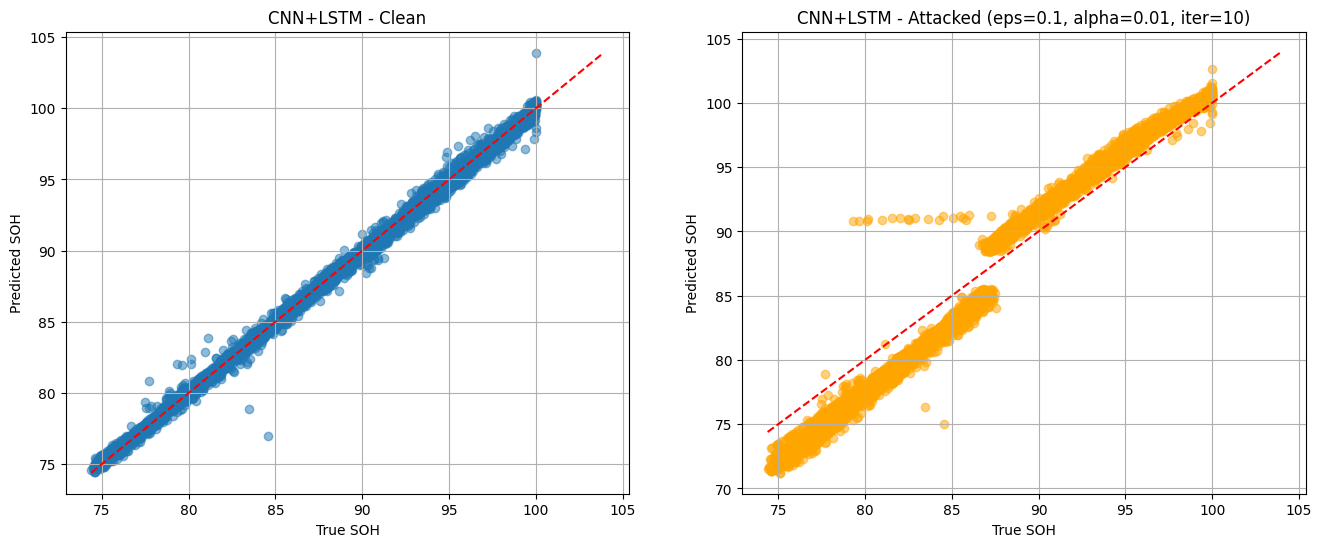

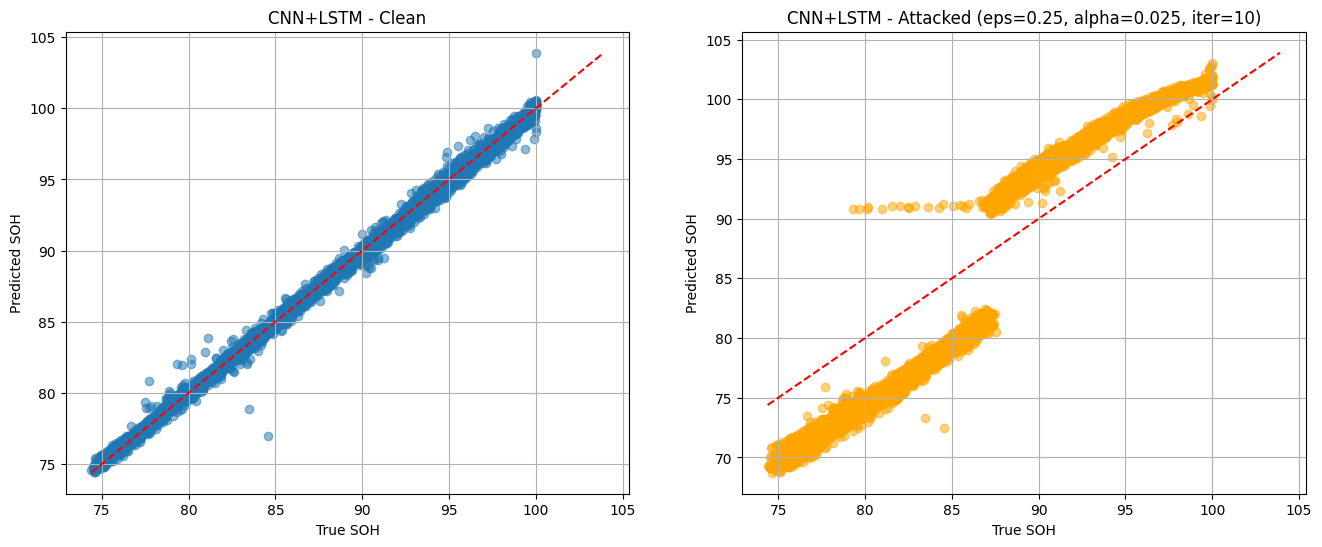

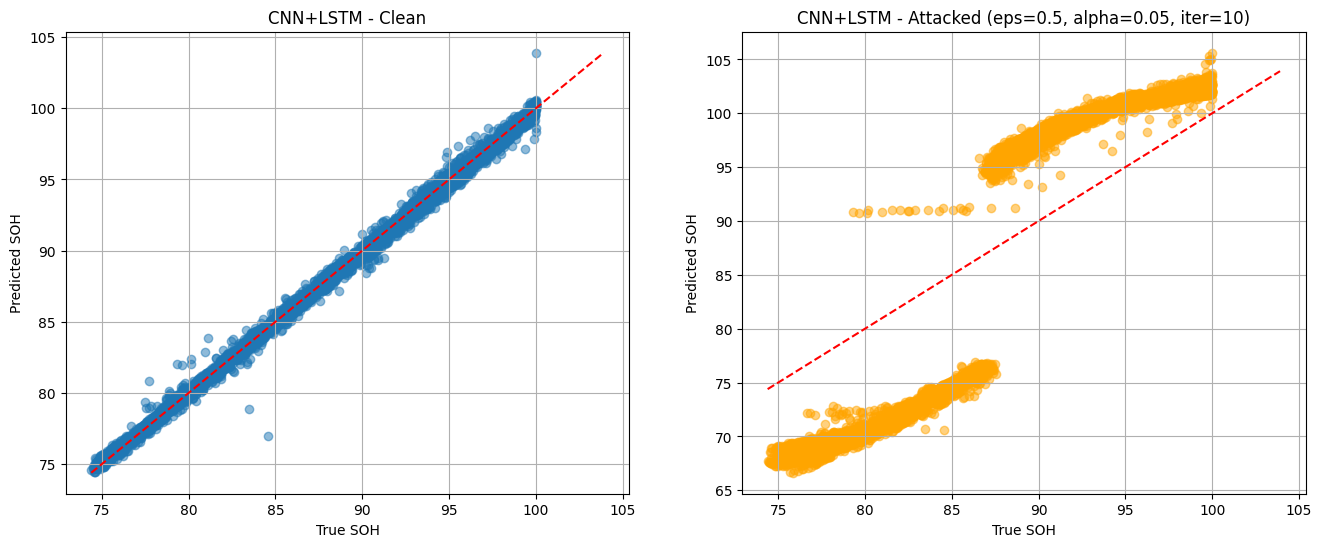

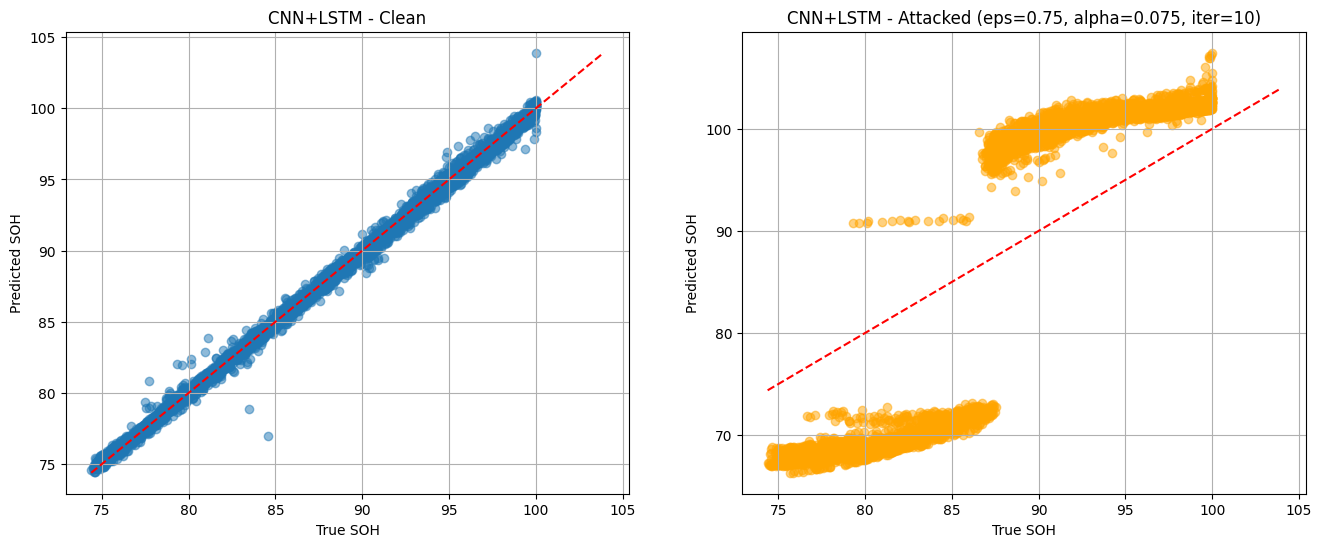

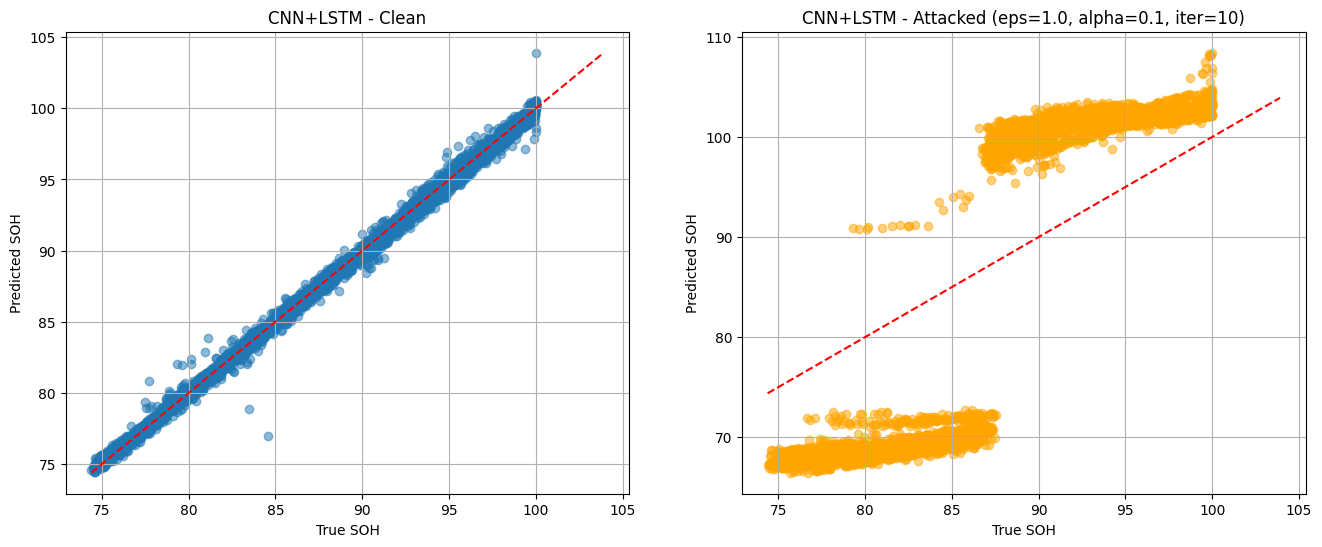

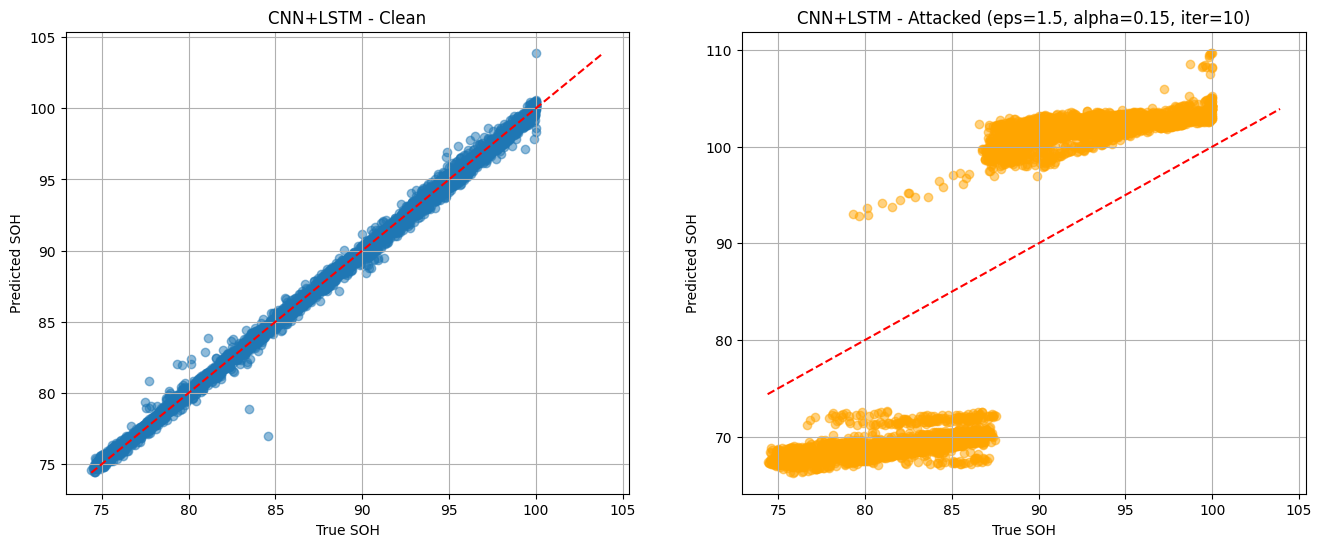

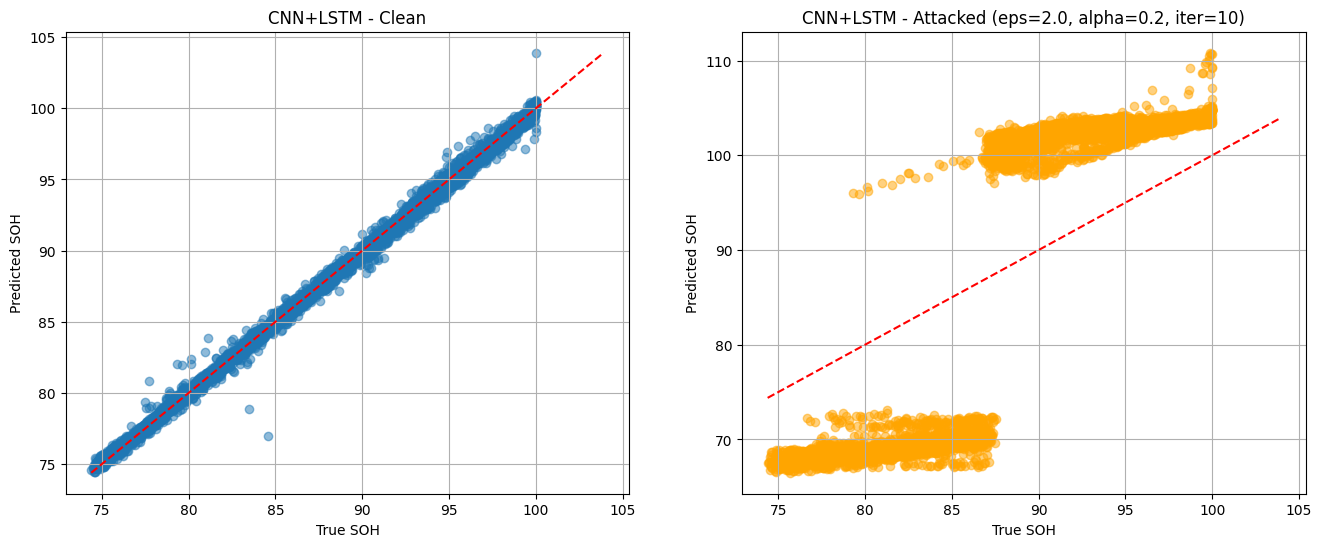


Adversarial Evaluation Results – CNN+LSTM
  Epsilon    MAE (Clean)    MAE (Attacked)     ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  -------  --------------  -----------------
   0.1000         0.2723            1.9446   1.6722          0.0031             0.0229
   0.2500         0.2723            4.5386   4.2663          0.0031             0.0533
   0.5000         0.2723            8.0260   7.7537          0.0031             0.0940
   0.7500         0.2723            9.8677   9.5953          0.0031             0.1155
   1.0000         0.2723           10.4986  10.2262          0.0031             0.1227
   1.5000         0.2723           10.8226  10.5502          0.0031             0.1262
   2.0000         0.2723           10.9608  10.6884          0.0031             0.1276


In [15]:
results_cnn_lstm = run_attack_evaluation(
    model=cnn_lstm,
    model_name="CNN+LSTM",
    attack_fn=pgd_attack_batch,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test_norm,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=epsilon_physical_values,
    clip_min = clip_min,
    clip_max = clip_max,
    num_iter=10,
    scaler_std = preprocessor.ic_scaler.scale_,
    plot=True   # True only when you want plots
)

----------
CNN + GRU
----------


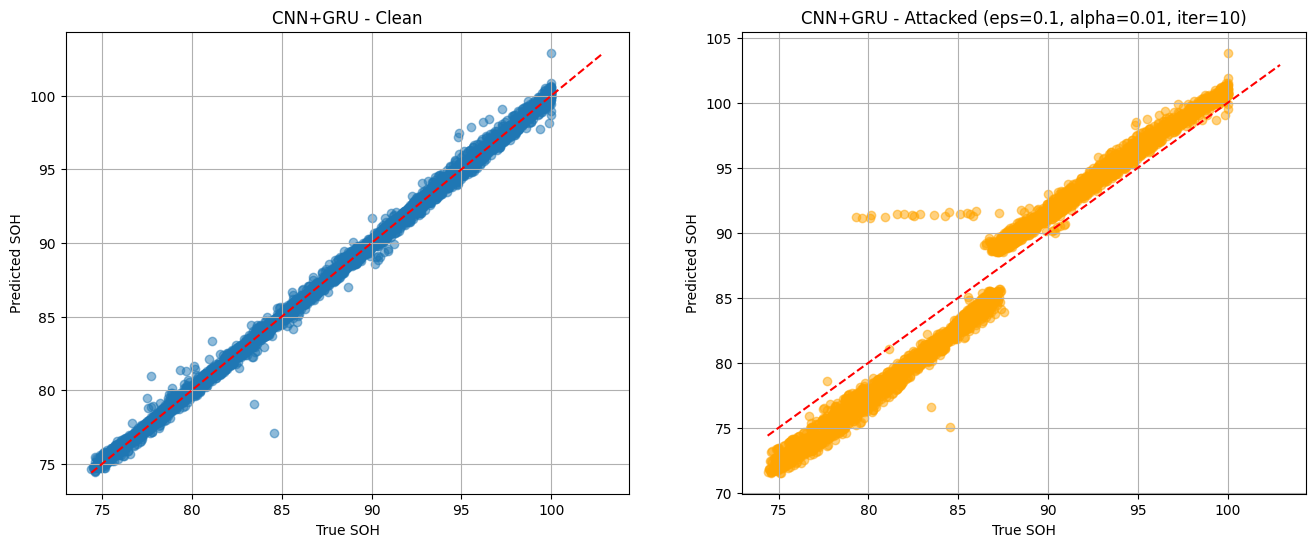

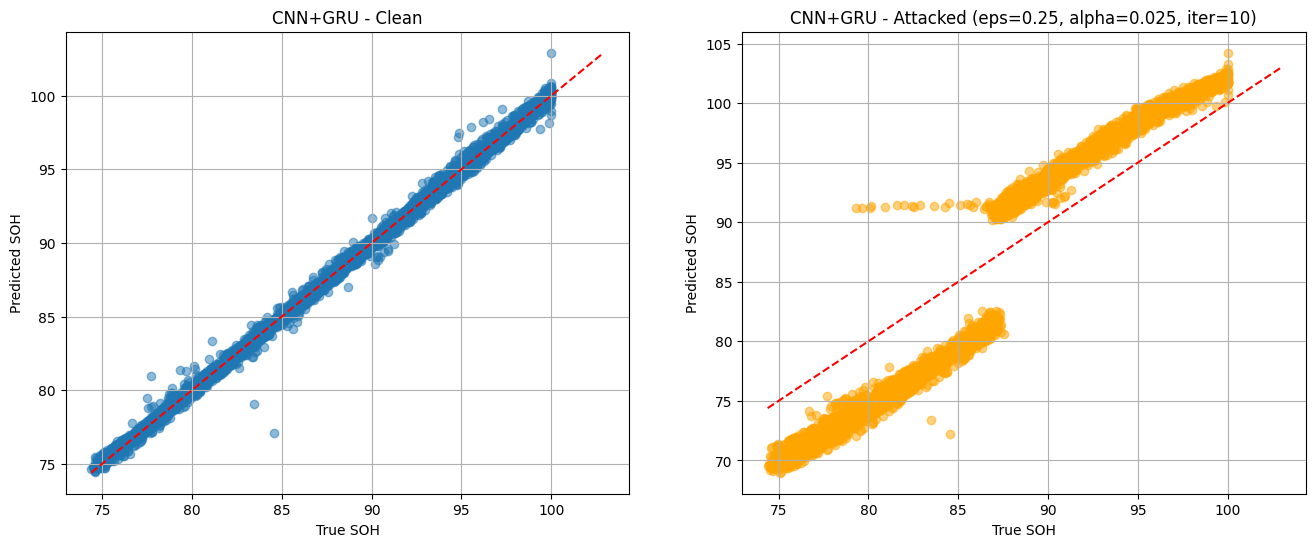

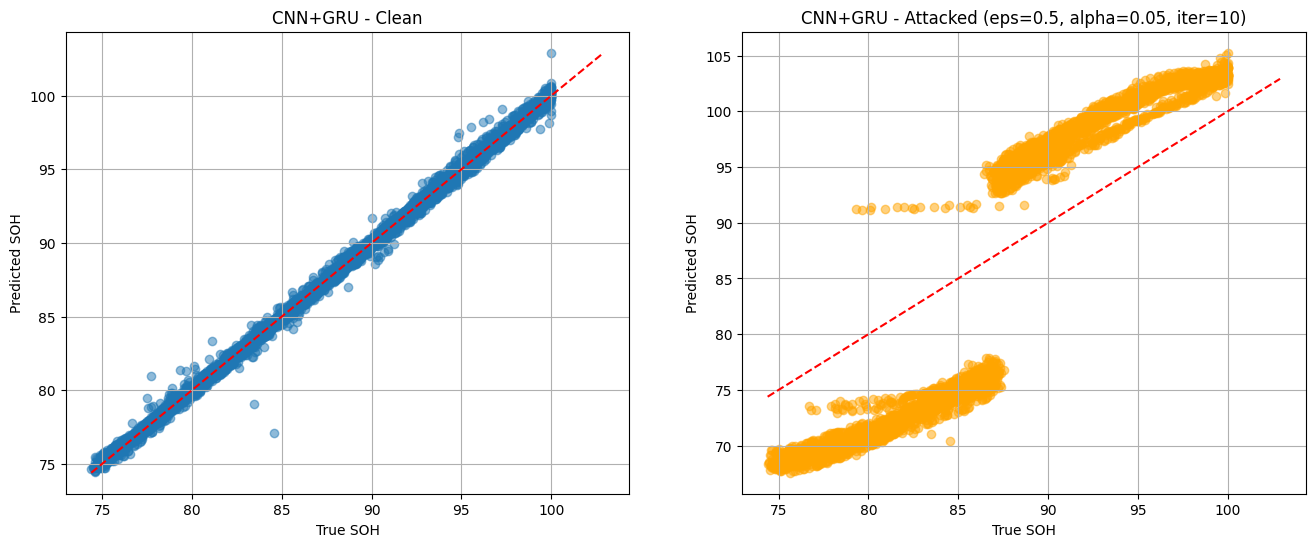

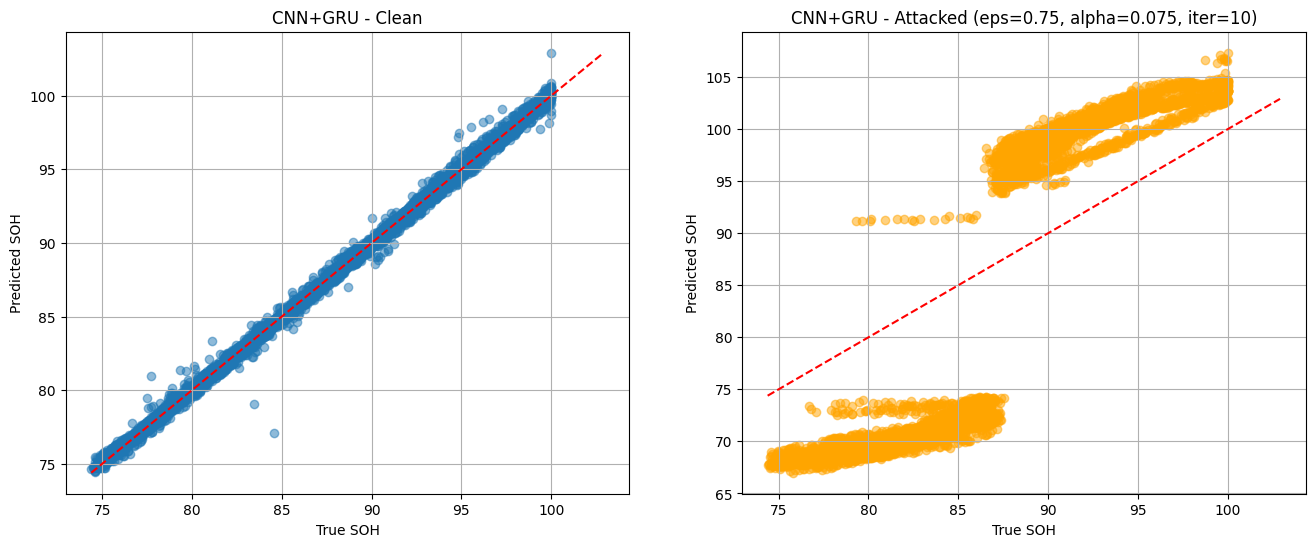

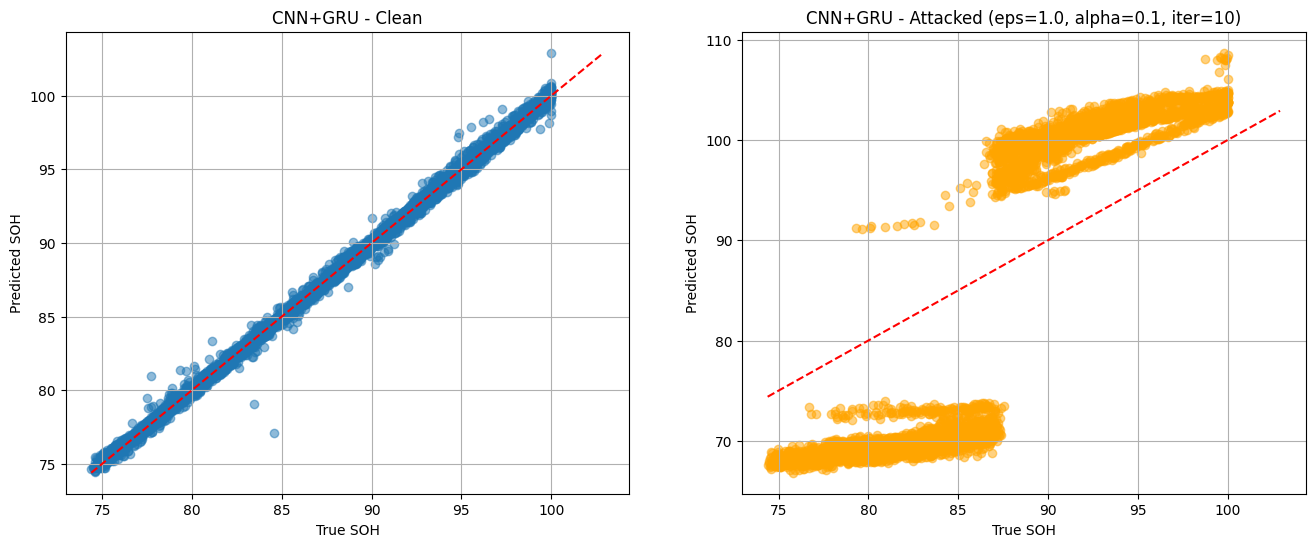

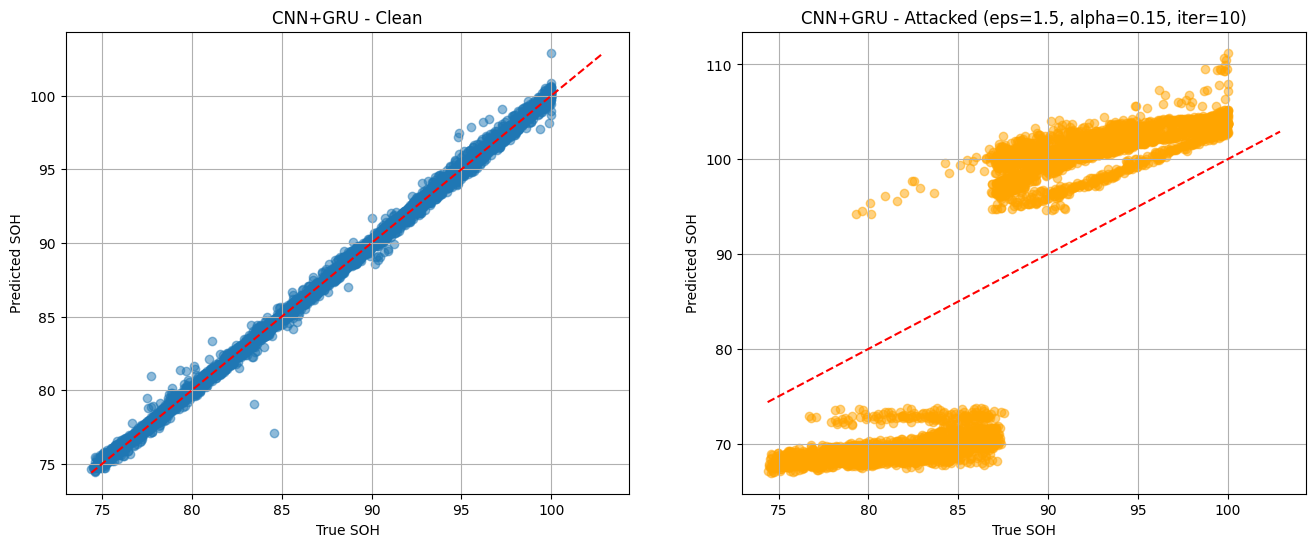

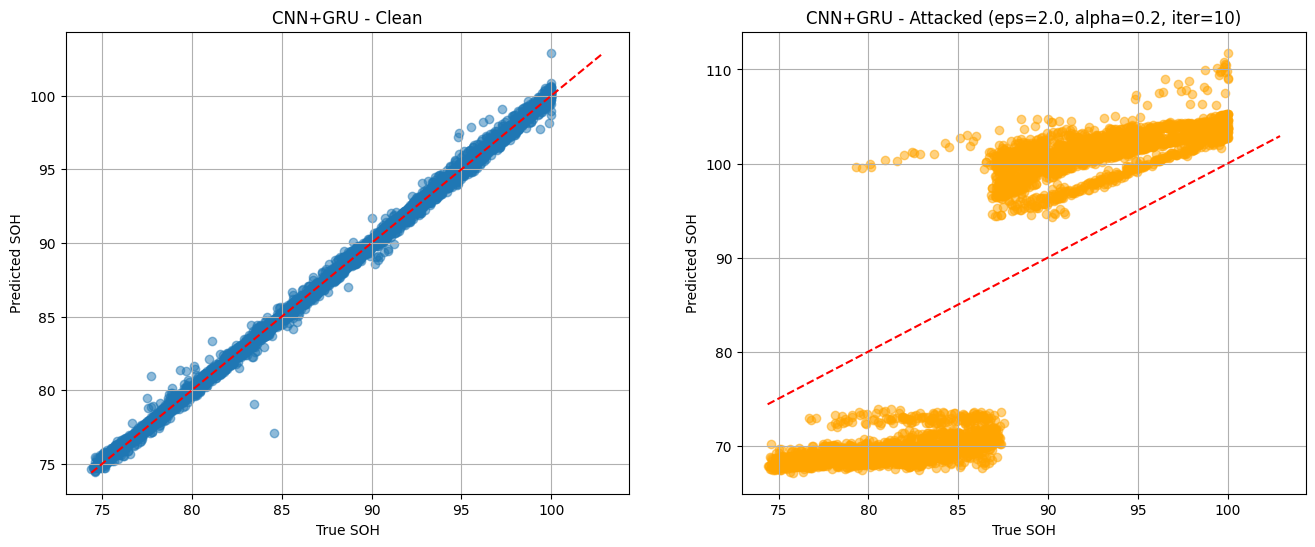


Adversarial Evaluation Results – CNN+GRU
  Epsilon    MAE (Clean)    MAE (Attacked)     ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  -------  --------------  -----------------
   0.1000         0.2500            2.0176   1.7676          0.0029             0.0238
   0.2500         0.2500            4.4503   4.2003          0.0029             0.0522
   0.5000         0.2500            7.6348   7.3848          0.0029             0.0893
   0.7500         0.2500            9.3888   9.1388          0.0029             0.1097
   1.0000         0.2500           10.0227   9.7728          0.0029             0.1170
   1.5000         0.2500           10.3093  10.0594          0.0029             0.1203
   2.0000         0.2500           10.3227  10.0727          0.0029             0.1204


In [16]:
print("----------")
print("CNN + GRU")
print("----------")

cnn_gru = keras.models.load_model(r"../../Models/CNN_GRU_NT.keras")

results_cnn_gru = run_attack_evaluation(
    model=cnn_gru,
    model_name="CNN+GRU",
    attack_fn=pgd_attack_batch,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test_norm,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=epsilon_physical_values,
    clip_min = clip_min,
    clip_max = clip_max,
    num_iter=10,
    scaler_std = preprocessor.ic_scaler.scale_,
    plot=True   # True only when you want plots
)


---
RCN
---


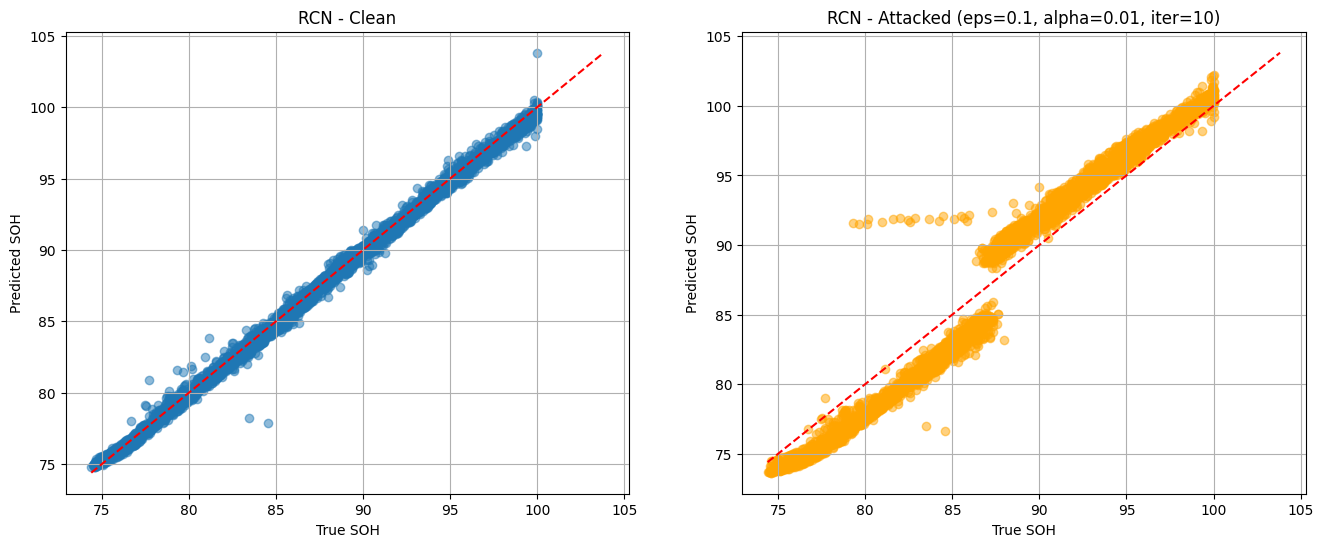

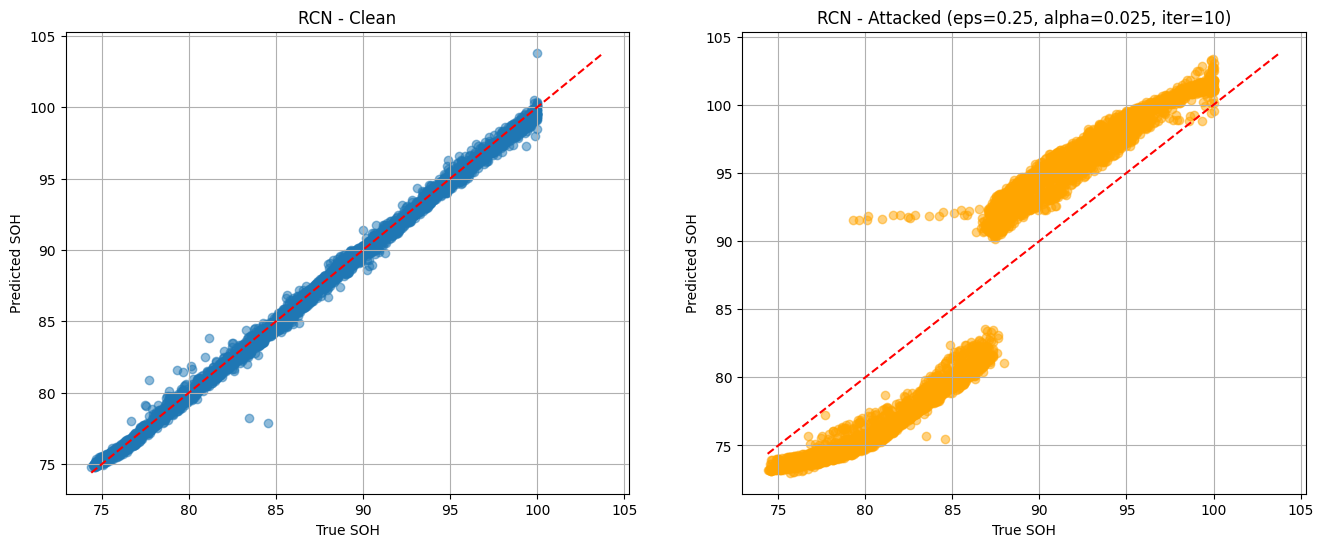

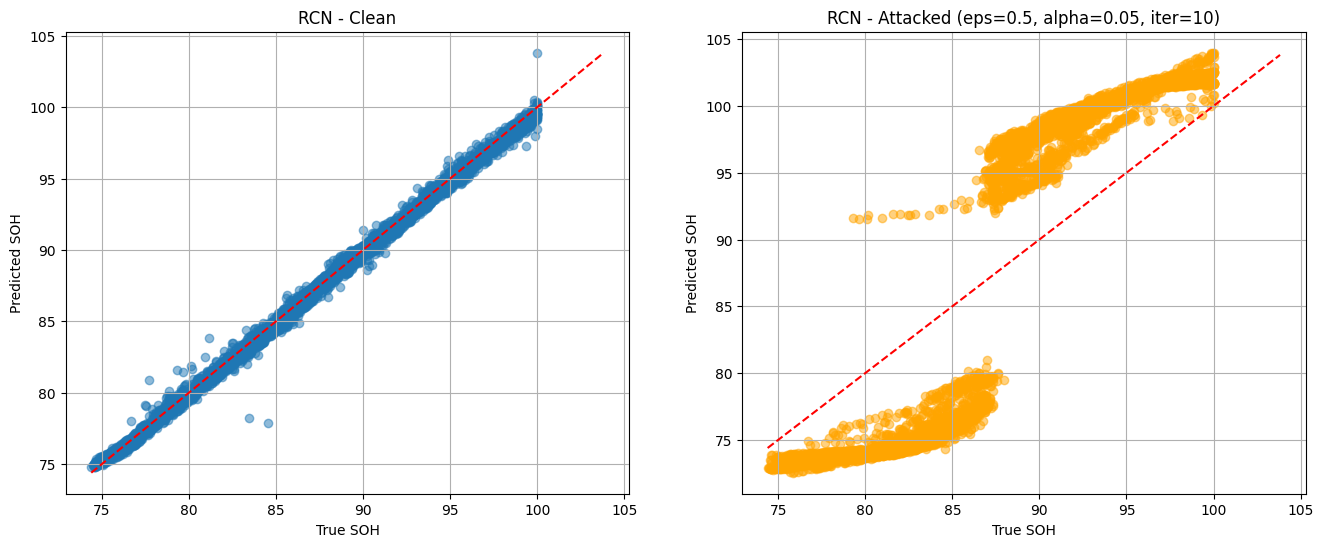

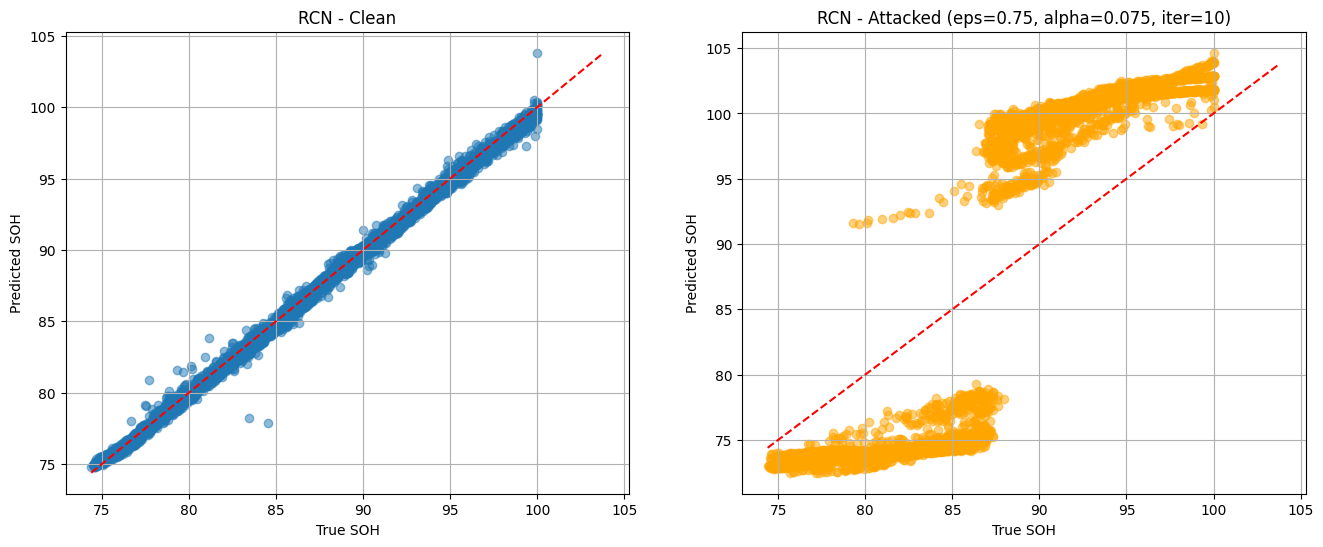

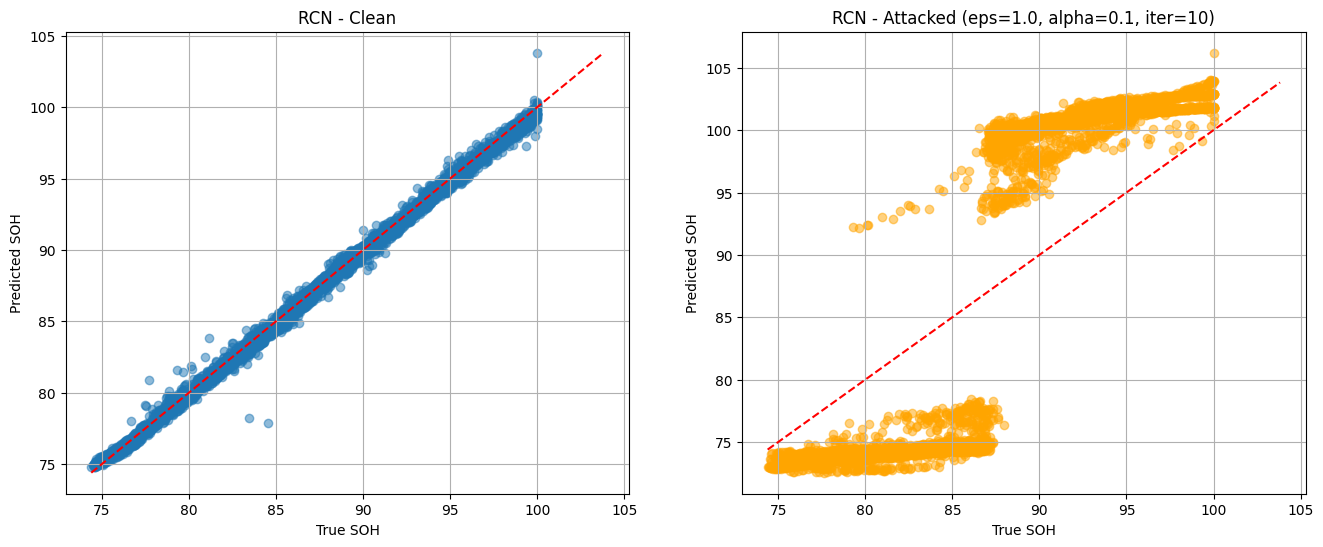

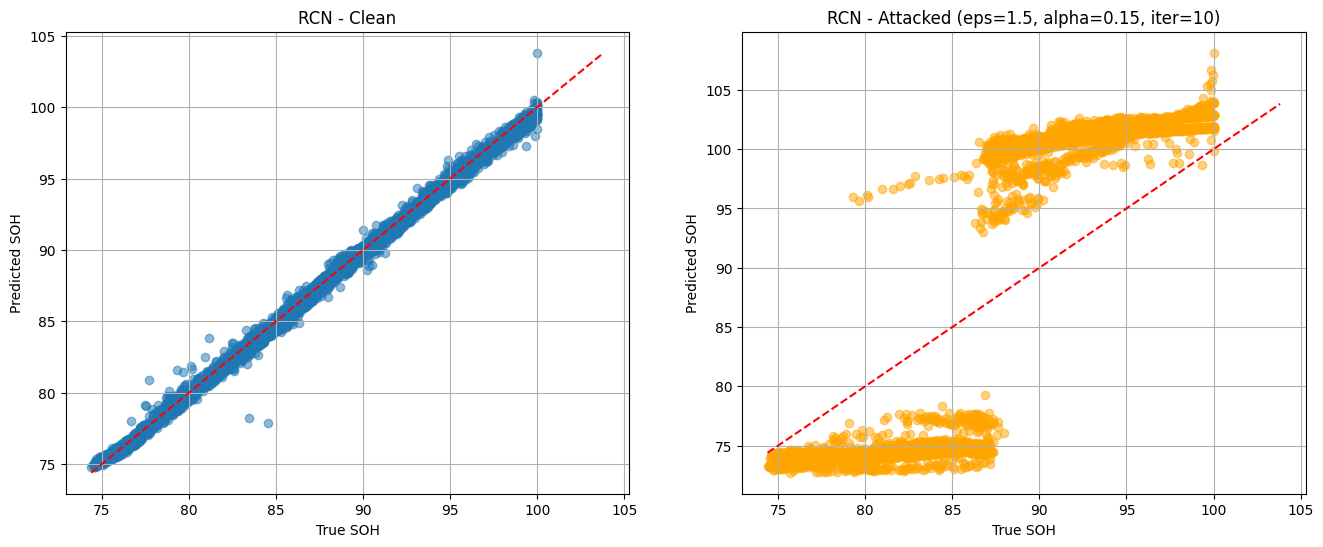

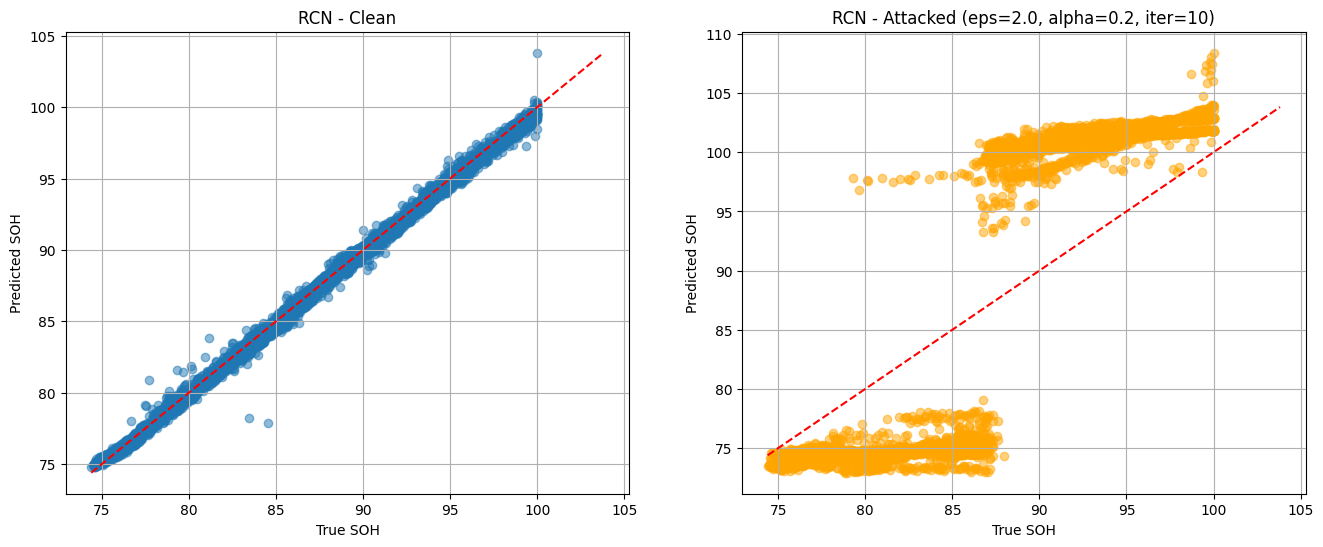


Adversarial Evaluation Results – RCN
  Epsilon    MAE (Clean)    MAE (Attacked)    ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  ------  --------------  -----------------
   0.1000         0.2750            1.9000  1.6250          0.0031             0.0222
   0.2500         0.2750            4.0587  3.7837          0.0031             0.0471
   0.5000         0.2750            6.3571  6.0821          0.0031             0.0734
   0.7500         0.2750            7.2840  7.0090          0.0031             0.0839
   1.0000         0.2750            7.5556  7.2806          0.0031             0.0869
   1.5000         0.2750            7.6415  7.3665          0.0031             0.0878
   2.0000         0.2750            7.5867  7.3117          0.0031             0.0870


In [17]:
print("---")
print("RCN")
print("---")
rcn = keras.models.load_model(r"../../Models/RCN_NT.keras")

results_rcn = run_attack_evaluation(
    model=rcn,
    model_name="RCN",
    attack_fn=pgd_attack_batch,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test_norm,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=epsilon_physical_values,
    clip_min = clip_min,
    clip_max = clip_max,
    num_iter=10,
    scaler_std = preprocessor.ic_scaler.scale_,
    plot=True   # True only when you want plots
)

---
CNN
---


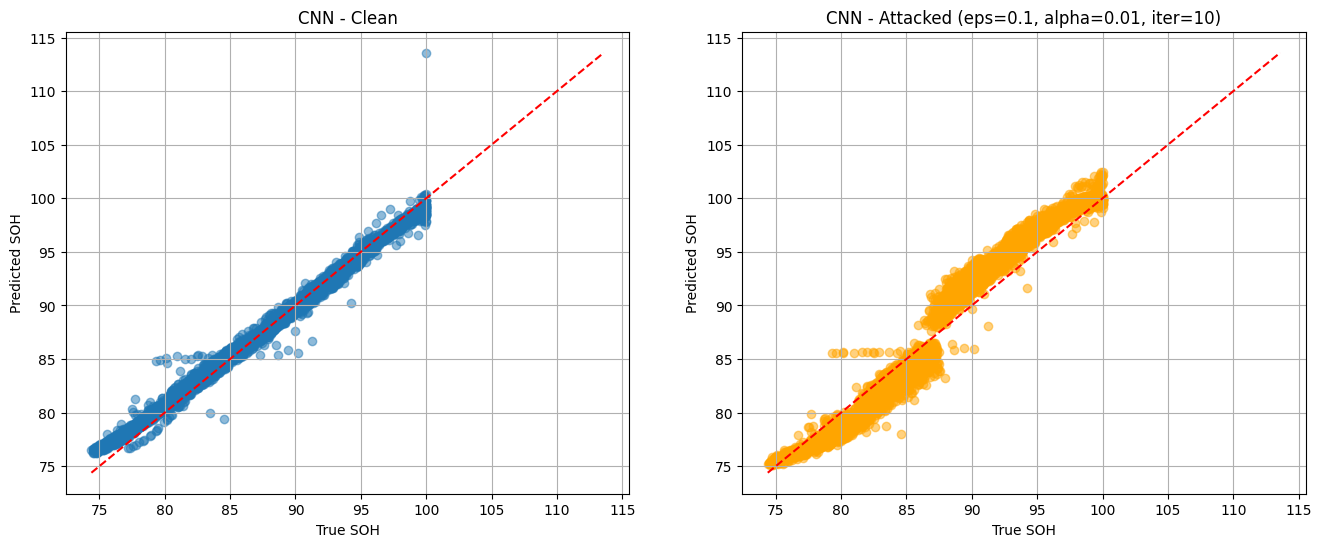

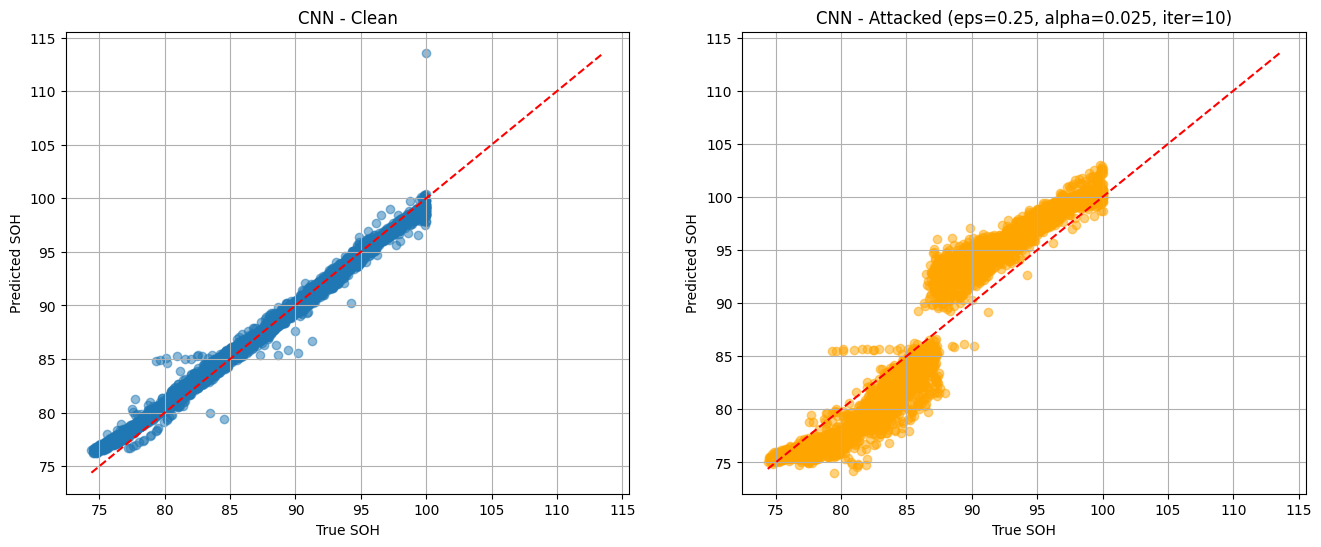

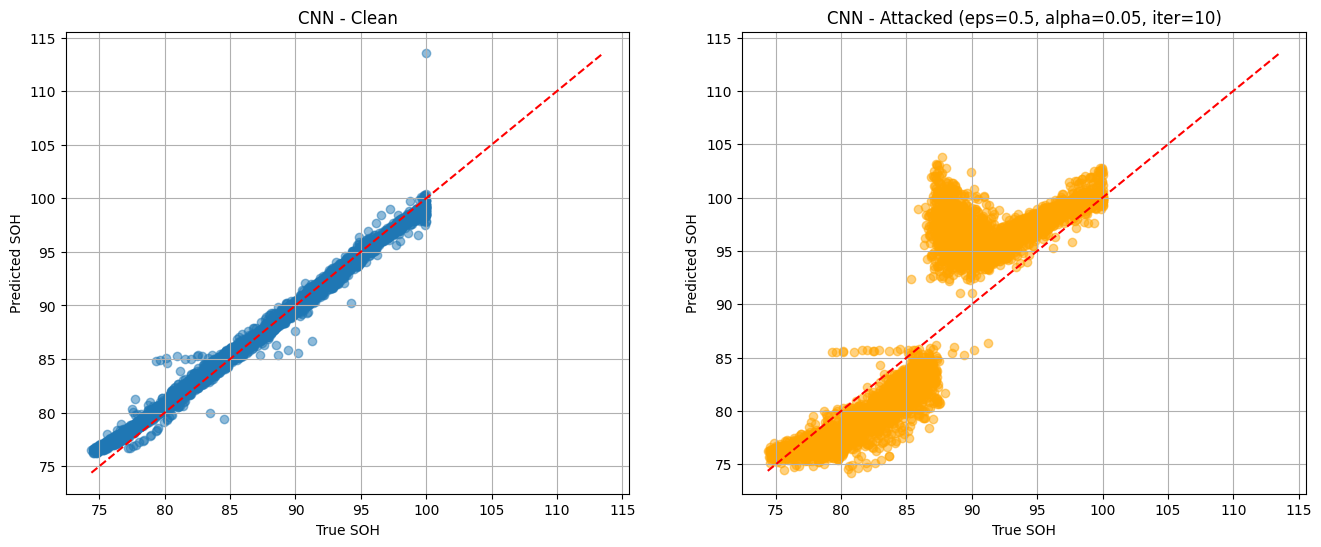

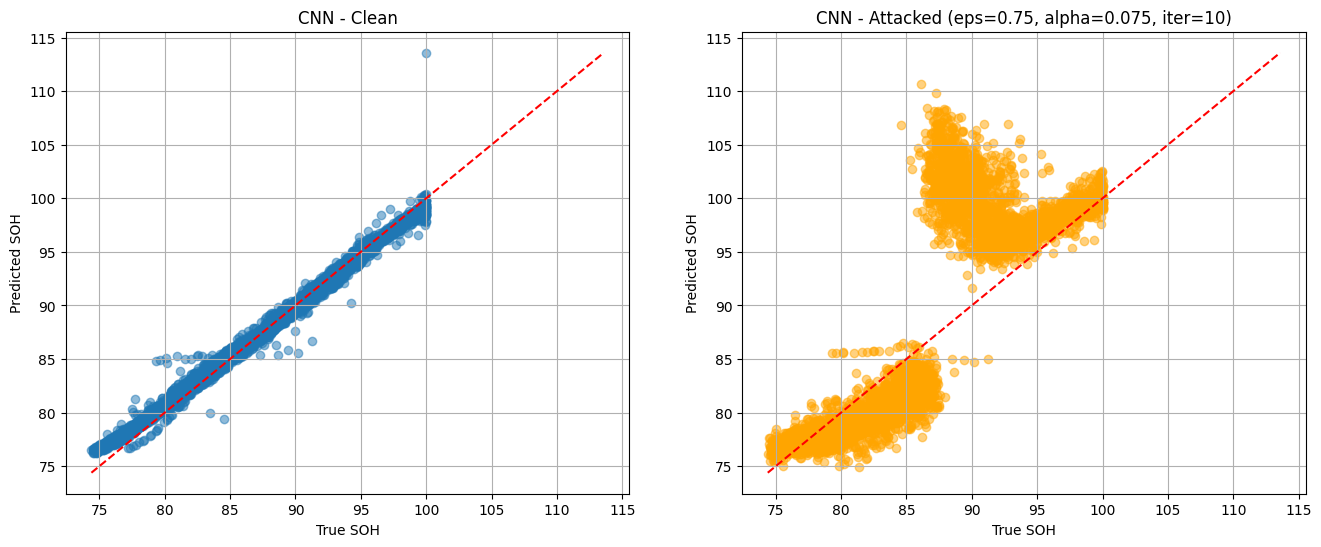

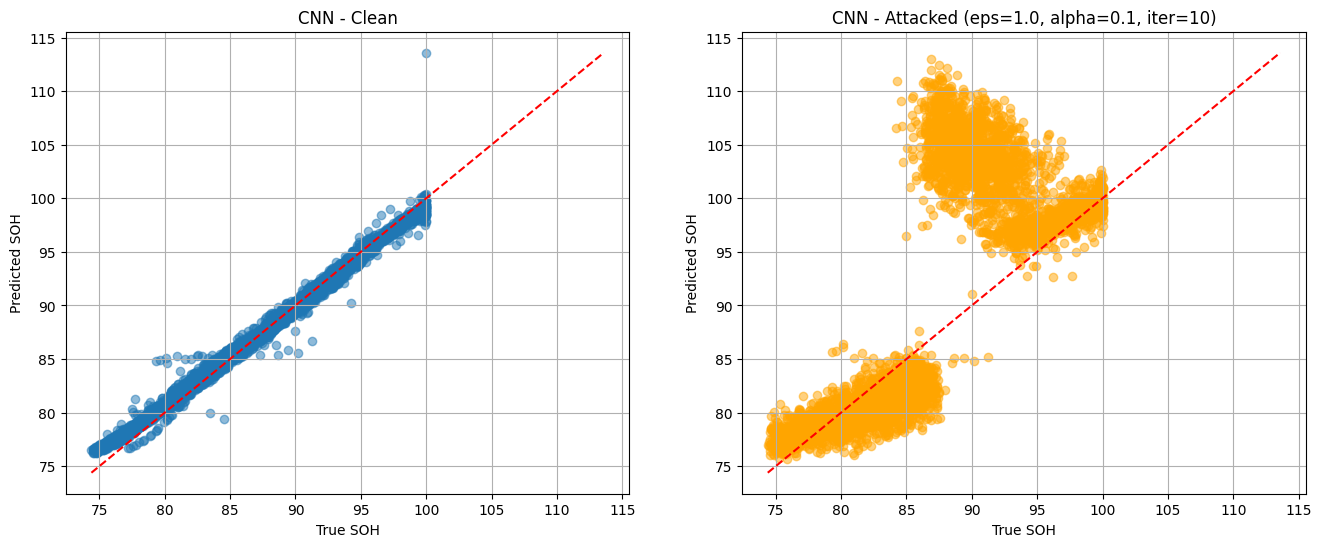

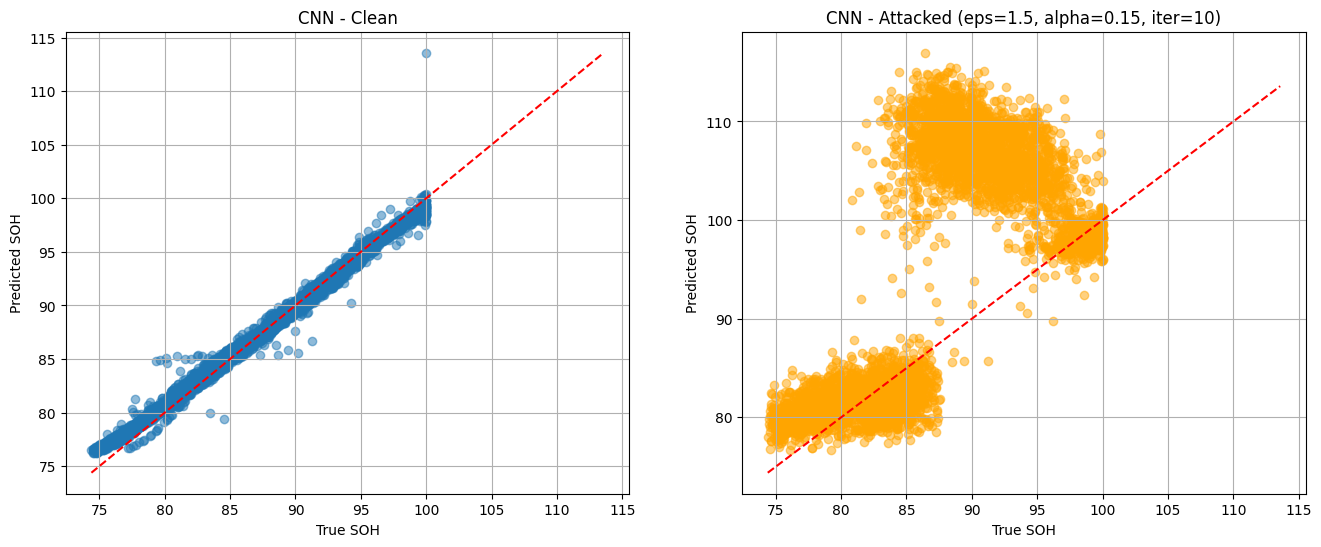

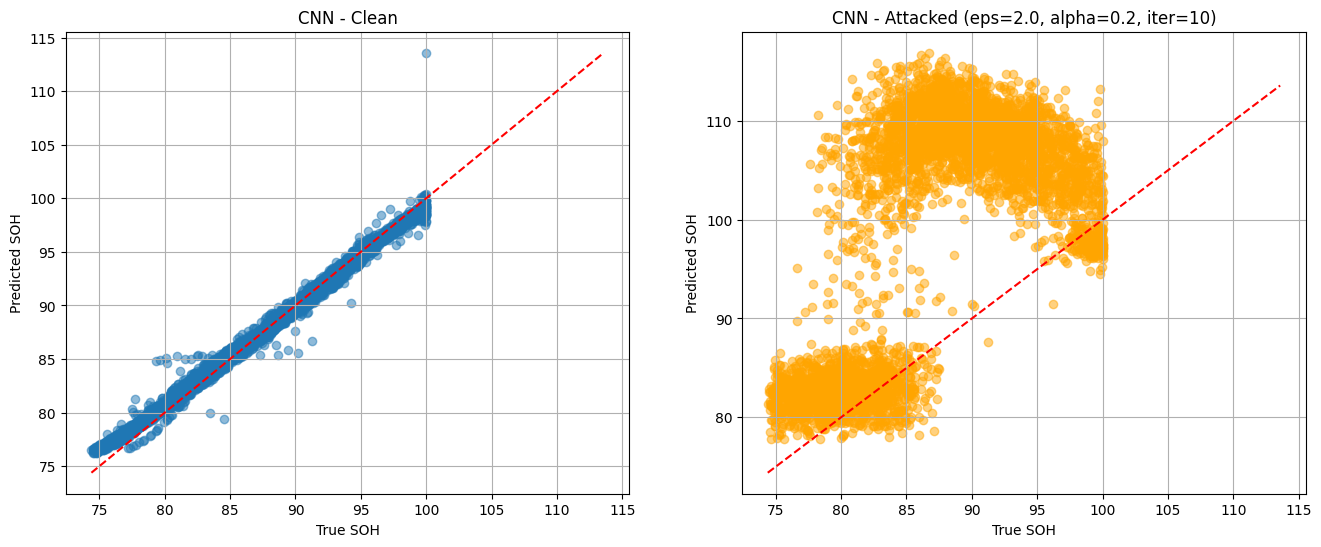


Adversarial Evaluation Results – CNN
  Epsilon    MAE (Clean)    MAE (Attacked)     ΔMAE    MAPE (Clean)    MAPE (Attacked)
---------  -------------  ----------------  -------  --------------  -----------------
   0.1000         0.5964            1.6078   1.0115          0.0071             0.0183
   0.2500         0.5964            2.5867   1.9904          0.0071             0.0296
   0.5000         0.5964            3.4817   2.8854          0.0071             0.0398
   0.7500         0.5964            4.5356   3.9393          0.0071             0.0516
   1.0000         0.5964            5.8790   5.2826          0.0071             0.0665
   1.5000         0.5964            8.8725   8.2761          0.0071             0.1005
   2.0000         0.5964           12.6585  12.0621          0.0071             0.1448


In [25]:
print("---")
print("CNN")
print("---")
cnn = keras.models.load_model(r"../../Models/CNN_NT.keras")

results_cnn = run_attack_evaluation(
    model=cnn,
    model_name="CNN",
    attack_fn=pgd_attack_batch,
    X_ic_test=X_ic_test,
    X_context_test=X_context_test,
    y_test_norm=y_test_norm,
    y_std=y_std,
    y_mean=y_mean,
    eps_values=epsilon_physical_values,
    clip_min = clip_min,
    clip_max = clip_max,
    num_iter=10,
    scaler_std = preprocessor.ic_scaler.scale_,
    plot=True   # True only when you want plots
)

In [22]:
idx = 100   
epsilon = 0.1
orig_ic = X_ic_test[idx].reshape(-1)     
orig_ctx = X_context_test[idx].reshape(1,-1)
orig_true = y_test_norm[idx] * y_std + y_mean

adv_ic = pgd_attack_batch(
    cnn_gru,
    X_ic_test[idx:idx+1],     
    X_context_test[idx:idx+1],
    y_test_norm[idx:idx+1],
    preprocessor.ic_scaler.scale_,
    0.05,
    0.5,
    10,
    clip_min,
    clip_max
).numpy()

adv_ic = adv_ic.reshape(-1)

y_pred_orig = cnn_gru.predict([X_ic_test[idx:idx+1], X_context_test[idx:idx+1]], verbose=0)[0][0]
y_pred_adv  = cnn_gru.predict([adv_ic.reshape(1,-1,1), X_context_test[idx:idx+1]], verbose=0)[0][0]

y_pred_orig = y_pred_orig * y_std + y_mean
y_pred_adv = y_pred_adv * y_std + y_mean

orig_true = orig_true

print("Original pred:", y_pred_orig)
print("Adversarial pred:", y_pred_adv)
print("True value:", orig_true)

Original pred: 86.04521572630256
Adversarial pred: 75.72312081322907
True value: 86.45


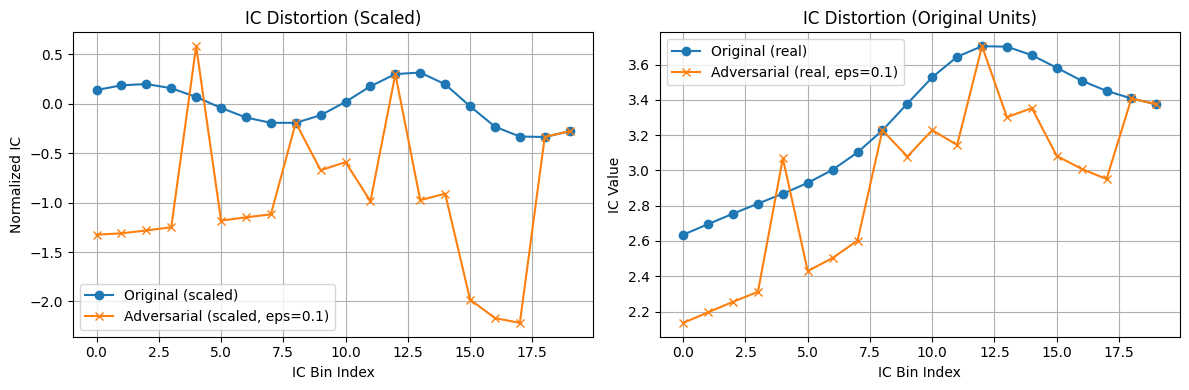

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# ensure numpy 1D
orig_ic_np = np.asarray(orig_ic).reshape(-1)
adv_ic_np  = np.asarray(adv_ic).reshape(-1)

# from your fitted scaler
ic_mean = preprocessor.ic_scaler.mean_      # shape (20,)
ic_std  = preprocessor.ic_scaler.scale_     # shape (20,)

# inverse-transform to original IC units
orig_ic_real = orig_ic_np * ic_std + ic_mean
adv_ic_real  = adv_ic_np  * ic_std + ic_mean

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Scaled
ax[0].plot(orig_ic_np, marker='o', label='Original (scaled)')
ax[0].plot(adv_ic_np, marker='x', label=f'Adversarial (scaled, eps={epsilon})')
ax[0].set_title('IC Distortion (Scaled)')
ax[0].set_xlabel('IC Bin Index')
ax[0].set_ylabel('Normalized IC')
ax[0].grid(True)
ax[0].legend()

# Original units
ax[1].plot(orig_ic_real, marker='o', label='Original (real)')
ax[1].plot(adv_ic_real, marker='x', label=f'Adversarial (real, eps={epsilon})')
ax[1].set_title('IC Distortion (Original Units)')
ax[1].set_xlabel('IC Bin Index')
ax[1].set_ylabel('IC Value')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


In [24]:
print("Original IC :", orig_ic_real)
print("Adversarial IC ", adv_ic_real)

Original IC : [2.63544703 2.69571938 2.75490791 2.81182622 2.86827362 2.9293879
 3.00376949 3.10226877 3.22759195 3.37872811 3.52842484 3.64460935
 3.70479718 3.7019922  3.65372201 3.58225113 3.50893358 3.45112486
 3.40843957 3.37470359]
Adversarial IC  [2.13544701 2.19571939 2.2549079  2.31182627 3.06827359 2.42938797
 2.50376951 2.60226875 3.22759194 3.07872808 3.22842479 3.14460945
 3.70479718 3.30199223 3.353722   3.08225113 3.00893358 2.95112494
 3.40843957 3.3747036 ]
